# Semester 4 Coding Portfolio Topic 1 Formative Part 1/1:
# Regularisation for Regression Models

This notebook focuses on **why** regularisation helps, and how to **see** it in practice.

We cover:

1. **Overfitting as “too much flexibility”** (visual): polynomial regression + how an **L1** penalty (Lasso) reduces complexity  
2. Load and preprocess the **Global Terrorism** dataset 
3. **Ridge regression (L2)**: how coefficients shrink as `alpha` increases  
4. **Bootstrap inference**: compare parameter uncertainty for **OLS vs Ridge**  
5. **Prediction**: predicted vs observed for both models (+ simple metrics)

> **Note.** L1 regularisation corresponds to **Lasso**; L2 corresponds to **Ridge**.  
> We use Lasso in the toy example for the *sparsity/feature selection* intuition, then Ridge for the main dataset (multicollinearity stability + shrinkage).

This notebook is expected to take around 10 hours to complete:
 - 4 hours for this formative notebook
 - 6 hours of self-study on the topics covered by this notebook

In [1]:
# TODO: Please enter your student number here
STUDENT_NUMBER = 15120139

## Setup

In [2]:
# Load libraries
import numpy as np
np.set_printoptions(suppress=True, precision=6)

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
from sklearn.utils import resample

import statsmodels.api as sm
from scipy.stats import spearmanr

import sem4_topic1_formative1_tests

# Reproducibility helper
RNG = np.random.default_rng(42)


---

# Part 0 — Warm-up intuition: Overfitting and L1 regularisation (Lasso)

## A visually “too expressive” linear model
A linear regression model can become extremely flexible if we add many engineered features (e.g., high-degree polynomials).
That flexibility can fit noise — **overfitting**.

We'll:
- generate a 1D dataset
- fit a high-degree polynomial **OLS** model
- compare it to **Lasso (L1)**, which shrinks many coefficients toward exactly zero

## The mathematics of the L1 penalty (Lasso)

Let $X\in \mathbb{R}^{n\times p}$ be the design matrix, $y\in\mathbb{R}^n$ the response, and $\beta\in\mathbb{R}^p$ the parameters.

**OLS** solves:
$
\hat\beta_{\text{OLS}} = \arg\min_{\beta} \; \|y - X\beta\|_2^2
$

**Lasso (L1)** solves:
$
\hat\beta_{\text{L1}} = \arg\min_{\beta} \; \|y - X\beta\|_2^2 + \alpha \|\beta\|_1
$
where $\|\beta\|_1 = \sum_{j=1}^p |\beta_j|$.

Key intuition:
- The **absolute value** penalty creates “corners” in the optimisation geometry
- Those corners make it common for the optimum to land on axes → **exact zeros**
- So Lasso tends to **select features** (sparse solutions)
- We are penalising optimisation solutions with large coefficients and favouring sparse solutions (more zero-valued parameters)

We'll see this happen in the coefficient plot.


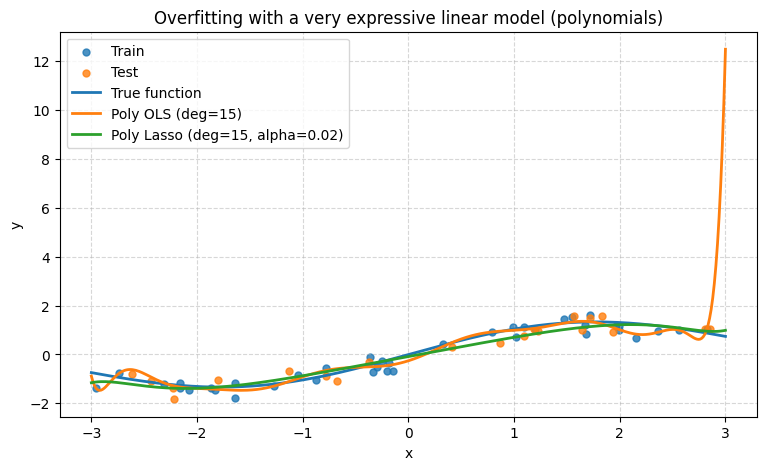

In [3]:
# Generate synthetic 1D regression data: a smooth signal + noise
n = 60
X = RNG.uniform(-3, 3, size=(n, 1))
y_true = np.sin(X[:, 0]) + 0.2 * X[:, 0]
y = y_true + RNG.normal(0, 0.35, size=n)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

# A very expressive model: polynomial features degree 15 + OLS
deg = 15
ols_poly = Pipeline([
    ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

# Lasso on the same features
lasso_poly = Pipeline([
    ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lasso", Lasso(alpha=0.02, max_iter=20000))
])

# Fit both models
ols_poly.fit(X_train, y_train)
lasso_poly.fit(X_train, y_train)

# Grid for plotting
x_grid = np.linspace(-3, 3, 400).reshape(-1, 1)
y_ols = ols_poly.predict(x_grid)
y_lasso = lasso_poly.predict(x_grid)

plt.figure(figsize=(9, 5))
plt.scatter(X_train[:, 0], y_train, s=25, alpha=0.8, label="Train")
plt.scatter(X_test[:, 0], y_test, s=25, alpha=0.8, label="Test")
plt.plot(x_grid[:, 0], np.sin(x_grid[:, 0]) + 0.2 * x_grid[:, 0], linewidth=2, label="True function")
plt.plot(x_grid[:, 0], y_ols, linewidth=2, label=f"Poly OLS (deg={deg})")
plt.plot(x_grid[:, 0], y_lasso, linewidth=2, label=f"Poly Lasso (deg={deg}, alpha=0.02)")
plt.title("Overfitting with a very expressive linear model (polynomials)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

### What should you notice?

- **OLS polynomial** can bend dramatically to match training points, especially at the edges.
- **Lasso** is still flexible, but tends to be smoother because many polynomial coefficients get shrunk to zero.

Let's *verify* that by inspecting coefficient magnitudes.


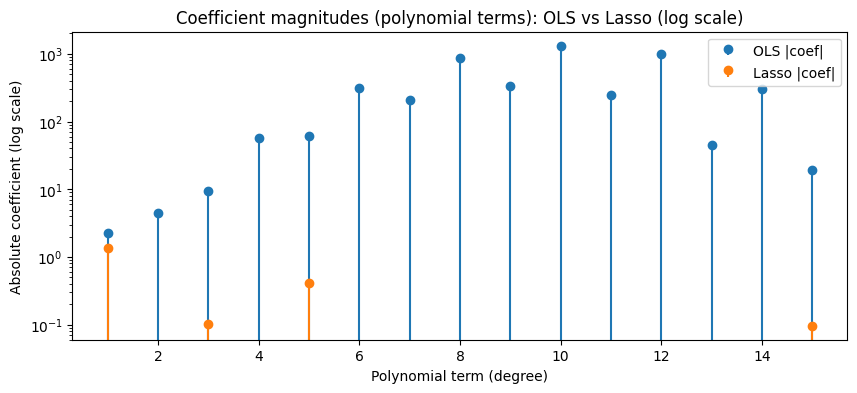

Number of exactly-zero coefficients in Lasso: 11


In [4]:
# Extract polynomial coefficients (excluding intercept) from the pipelines
ols_coef = ols_poly.named_steps["lr"].coef_
lasso_coef = lasso_poly.named_steps["lasso"].coef_

x = np.arange(1, len(ols_coef) + 1)

plt.figure(figsize=(10, 4))

plt.stem(x, np.abs(ols_coef),
         basefmt=" ",
         linefmt="C0-",
         markerfmt="C0o",
         label="OLS |coef|")

plt.stem(x, np.abs(lasso_coef),
         basefmt=" ",
         linefmt="C1-",
         markerfmt="C1o",
         label="Lasso |coef|")

plt.yscale("log")  
plt.title("Coefficient magnitudes (polynomial terms): OLS vs Lasso (log scale)")
plt.xlabel("Polynomial term (degree)")
plt.ylabel("Absolute coefficient (log scale)")
plt.legend()
plt.grid(False)
plt.show()

print("Number of exactly-zero coefficients in Lasso:", np.sum(lasso_coef == 0.0))

---

# Part 1 — Load & preprocess the Global Terrorism dataset

We now switch to the real dataset. The goal is to model:

- **Outcome**: `nkill` (number killed in an attack)  
- We work with `log(nkill + 1)` for stability and interpretability.

In this dataset:
- many covariates are correlated (multicollinearity),
- and there are many dummy variables (country/region/year/org),
so **regularisation becomes useful**.

> We intentionally keep all dummies (no dummy-trap worries) because Ridge is stable even with many correlated columns.



In [5]:
# Load the cleaned Global Terrorism Dataset
data_path = "sem4_topic1_formative1_data.csv"
df = pd.read_csv(data_path)

df.head()

,eventid,attack.24hours.plus,country,region,latitude,longitude,goal.pol.econ.rel,goal.coerce.intim.pub,goal.out.hum.law,doubt,doubt.which,multiple.attacks,success,suicide,unaffiliated.lone.attacker,nperps,attack.claim,nkill,nkill.us,nperps.kill,nwound,nwound.us,nperps.wound,property.damage.present,hostage,nhostage,nhostage.us,ransom,nreleased,perp.nat_neq_attack.loc,perp.nat_neq_victim.nat,victim.nat_neq_attack.loc,date,attack.length.days,weapdetail,attack.type_assassination,attack.type_hostage.taking..kidnapping.,attack.type_bombing.explosion,attack.type_facility.infrastructure.attack,attack.type_armed.assault,attack.type_hijacking,attack.type_unknown,attack.type_unarmed.assault,attack.type_hostage.taking..barricade.incident.,target.type_private.citizens...property,target.type_government..diplomatic.,target.type_journalists...media,target.type_police,target.type_utilities,target.type_military,target.type_government..general.,target.type_airports...aircraft,target.type_business,target.type_educational.institution,target.type_violent.political.party,target.type_religious.figures.institutions,target.type_unknown,target.type_transportation,target.type_tourists,target.type_ngo,target.type_telecommunication,target.type_food.or.water.supply,target.type_terrorists.non.state.militia,target.type_other,target.type_maritime,target.type_abortion.related,terrorist.org,terrorist.org.uncertainty,nperps.captured,weapon.type_unknown,weapon.type_explosives,weapon.type_incendiary,weapon.type_firearms,weapon.type_chemical,weapon.type_melee,weapon.type_sabotage.equipment,weapon.type_vehicle..not.to.include.vehicle.borne.explosives..i.e...car.or.truck.bombs.,weapon.type_fake.weapons,weapon.type_radiological,weapon.type_other,weapon.type_biological,property.damage.category
0,197000000001,0,Dominican Republic,Central America & Caribbean,18.4568,-69.9512,1,1,1,0.0000,NaN,0.0000,1,0,0,NaN,NaN,1.0000,NaN,NaN,0.0000,NaN,NaN,0.0000,0.0000,NaN,NaN,0.0000,NaN,0.0000,0.0000,0.0000,1970-07-02,0.0000,NaN,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,MANO-D,0.0000,NaN,1,0,0,0,0,0,0,0,0,0,0,0,No Damage
1,197000000002,0,Mexico,North America,19.3719,-99.0866,1,1,1,0.0000,NaN,0.0000,1,0,0,7.0000,NaN,0.0000,NaN,NaN,0.0000,NaN,NaN,0.0000,1.0000,1.0000,0.0000,1.0000,NaN,0.0000,1.0000,1.0000,1970-11-13,0.0000,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23rd of September Communist League,0.0000,NaN,1,0,0,0,0,0,0,0,0,0,0,0,No Damage
2,197001000001,0,Philippines,Southeast Asia,15.4786,120.5997,1,1,1,0.0000,NaN,0.0000,1,0,0,NaN,NaN,1.0000,NaN,NaN,0.0000,NaN,NaN,0.0000,0.0000,NaN,NaN,0.0000,NaN,NaN,NaN,1.0000,1970-01-09,0.0000,NaN,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Unknown,0.0000,NaN,1,0,0,0,0,0,0,0,0,0,0,0,No Damage
3,197001000002,0,Greece,Western Europe,37.9975,23.7627,1,1,1,0.0000,NaN,0.0000,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0000,0.0000,NaN,NaN,0.0000,NaN,NaN,NaN,1.0000,1970-01-21,0.0000,Explosive,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Unknown,0.0000,NaN,0,1,0,0,0,0,0,0,0,0,0,0,NaN
4,197001000003,0,Japan,East Asia,33.5804,130.3964,1,1,1,NaN,NaN,0.0000,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0000,0.0000,NaN,NaN,0.0000,NaN,NaN,NaN,1.0000,1970-01-19,0.0000,Incendiary,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Unknown,0.0000,NaN,0,0,1,0,0,0,0,0,0,0,0,0,NaN


In [6]:
# Basic feature engineering / dummies

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year.astype('category')

cat_cols = ['country', 'region', 'year', 'terrorist.org']
df_dummies = pd.get_dummies(df, columns=cat_cols, drop_first=False)

goal_cols = ['goal.pol.econ.rel', 'goal.coerce.intim.pub', 'goal.out.hum.law']
additional_cols = ['attack.24hours.plus', 'unaffiliated.lone.attacker', 'suicide', 'multiple.attacks', 'nperps']

attack_weapon_cols = [c for c in df.columns if c.startswith('attack.type_') or c.startswith('weapon.type_')]
dummy_cols = [c for c in df_dummies.columns if c.startswith(('country_', 'region_', 'year_', 'terrorist.org_'))]

X_cols = goal_cols + additional_cols + attack_weapon_cols + dummy_cols
Y_cols = ['nkill']

YX = df_dummies[Y_cols + X_cols].dropna()

# Subsample for speed/teaching
YX = YX.sample(n=1000, random_state=42)

# remove zero-variance columns
variances = YX.var(axis=0)
kept = variances != 0
YX = YX.loc[:, kept]
X_cols = [c for c in X_cols if kept.get(c, False)]

X = YX[X_cols]
Y = YX[Y_cols]

log_Y = np.log(Y + 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("X shape:", X_scaled.shape)
print("Y shape:", log_Y.shape)


X shape: (1000, 384)
Y shape: (1000, 1)


# Part 2 — Ridge regression: estimation and the role of `alpha`

Ridge regression solves:
$
\hat\beta_{\text{ridge}} = \arg\min_\beta \; \|y - X\beta\|_2^2 + \alpha\|\beta\|_2^2
$
where $\|\beta\|_2^2 = \sum_j \beta_j^2$.

Two key effects:

1. **Shrinkage:** as `alpha` increases, coefficients move toward 0  
2. **Stability:** even with multicollinearity, $X^TX + \alpha I$ is invertible

## Exercise 2A
We'll select `alpha` via cross-validation.


In [ ]:
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-5, 5, 300)

# TODO 1: RidgeCV Setup
# Create a RidgeCV model with:
# - alphas = alphas
# - fit_intercept=True
# - scoring = 'neg_mean_squared_error'
# Fit it to X_scaled and log_Y.

ridge_cv = RidgeCV(
    alphas=alphas,
    fit_intercept=True,
    scoring='neg_mean_squared_error'
)
ridge_cv.fit(X_scaled, log_Y)

optimal_alpha = ridge_cv.alpha_
print(f"Optimal alpha found via CV: {optimal_alpha:.6f}")

sem4_topic1_formative1_tests.test_ridgecv_setup(ridge_cv, alphas)

Optimal alpha found via CV: 723.655342


## Exercise 2B

In [9]:
# TODO 2: Fit Ridge Model
# Fit Ridge(alpha=optimal_alpha, fit_intercept=True) on X_scaled and log_Y

ridge_model = Ridge(alpha=optimal_alpha, fit_intercept=True)
ridge_model.fit(X_scaled, log_Y)
#. Your solution here ...

beta_hat = np.concatenate([ridge_model.intercept_.ravel(), ridge_model.coef_.ravel()])
beta_names = ['(intercept)'] + X_cols
print("Number of parameters (incl intercept):", len(beta_hat))

sem4_topic1_formative1_tests.test_ridge_model_fit(ridge_model, X_scaled, log_Y)

Number of parameters (incl intercept): 385


## 2.1 Visualising shrinkage as `alpha` increases

A simple summary is the **average absolute coefficient size**.  
As regularisation increases, coefficients shrink toward 0.


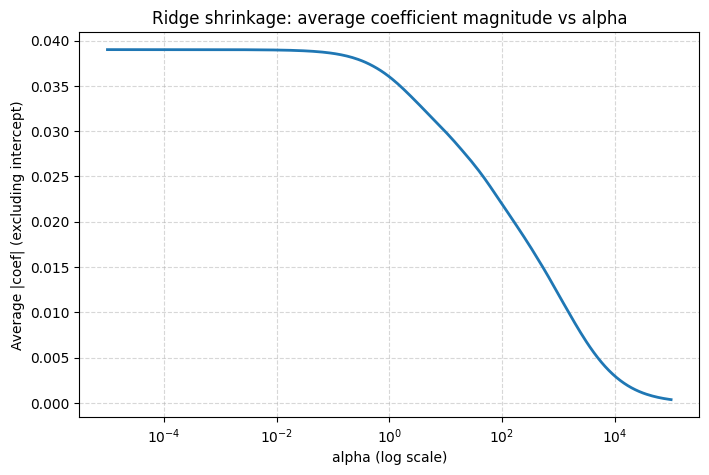

In [10]:
avg_abs = []
for a in alphas:
    m = Ridge(alpha=a, fit_intercept=True)
    m.fit(X_scaled, log_Y)
    avg_abs.append(np.mean(np.abs(m.coef_.ravel())))

plt.figure(figsize=(8, 5))
plt.plot(alphas, avg_abs, linewidth=2)
plt.xscale("log")
plt.xlabel("alpha (log scale)")
plt.ylabel("Average |coef| (excluding intercept)")
plt.title("Ridge shrinkage: average coefficient magnitude vs alpha")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.show()

A more detailed view is a **coefficient path** for a small set of variables.

We’ll pick a few interpretable variables (these should exist in `X_cols`).  
If a variable doesn’t exist, just change the names below.


In [12]:
# Pick some example variables to track (adjust if needed)
example_vars = [v for v in ['suicide', 'multiple.attacks', 'nperps', 'attack.24hours.plus'] if v in X_cols]
example_vars

['suicide', 'multiple.attacks', 'nperps', 'attack.24hours.plus']

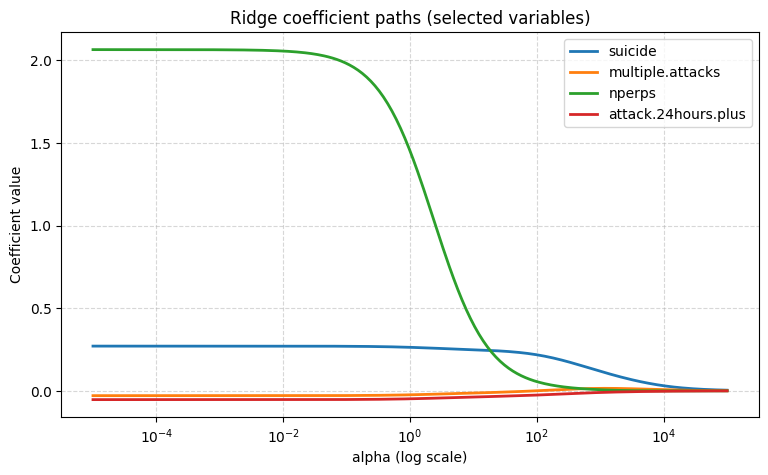

In [13]:
# Compute coefficient paths for the selected variables
paths = {v: [] for v in example_vars}

for a in alphas:
    m = Ridge(alpha=a, fit_intercept=True)
    m.fit(X_scaled, log_Y)
    coef_series = pd.Series(m.coef_.ravel(), index=X_cols)
    for v in example_vars:
        paths[v].append(coef_series[v])

plt.figure(figsize=(9, 5))
for v in example_vars:
    plt.plot(alphas, paths[v], label=v, linewidth=2)
plt.xscale("log")
plt.xlabel("alpha (log scale)")
plt.ylabel("Coefficient value")
plt.title("Ridge coefficient paths (selected variables)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.show()

### Main takeaway
- **L1 (Lasso)** induces sparsity of solutions: More zero-valued parameters, which is very good for interpretable models
- **L2 (Ridge)** simply induces smaller parameter coefficient

<img src="media/ridge_vs_lasso.png" width="800"/>


# Part 3 — Bootstrap inference: Ridge vs OLS

**Goal:** understand *uncertainty* about coefficients.

Bootstrap logic:
1. sample rows with replacement
2. refit the model
3. store coefficients
4. repeat → we get an empirical sampling distribution

We will compute bootstrap distributions for:
- **OLS** (no penalty)
- **Ridge** (alpha fixed to our CV-chosen value)

> Important: When predictors are highly collinear, OLS coefficients can have **huge variance**.

## Exercise 3A


In [15]:
n_boot = 600  # keep reasonable for class laptops

boot_ols = np.zeros((n_boot, len(X_cols) + 1))
boot_ridge = np.zeros((n_boot, len(X_cols) + 1))

# TODO 3: Bootstrap implementation for BOTH models
# For each bootstrap draw:
# - resample rows from (X_scaled, log_Y)
# - fit OLS (LinearRegression) with fit_intercept=True
# - fit Ridge(alpha=optimal_alpha) with fit_intercept=True
# - store intercept+coefs into boot_ols and boot_ridge

from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

for i in range(n_boot):
    Xb, yb = resample(X_scaled, log_Y, replace=True, random_state=42+i)

    # OLS model
    ols = LinearRegression(fit_intercept=True)
    ols.fit(Xb, yb)
    boot_ols[i, :] = np.concatenate([ols.intercept_.ravel(), ols.coef_.ravel()])

    # Ridge model
    rg = Ridge(alpha=optimal_alpha, fit_intercept=True)
    rg.fit(Xb, yb)
    boot_ridge[i, :] = np.concatenate([rg.intercept_.ravel(), rg.coef_.ravel()])

boot_ols.shape, boot_ridge.shape

sem4_topic1_formative1_tests.test_bootstrap_implementation(boot_ols, boot_ridge, n_boot, X_cols)

In [16]:
# Helper: bootstrap summary table
def bootstrap_summary(boot, names):
    se = boot.std(axis=0)
    ci_lo = np.percentile(boot, 2.5, axis=0)
    ci_hi = np.percentile(boot, 97.5, axis=0)
    med = np.percentile(boot, 50, axis=0)
    pr_pos = np.mean(boot > 0, axis=0)
    return pd.DataFrame({
        "Coefficient": names,
        "Median": med,
        "CI 2.5%": ci_lo,
        "CI 97.5%": ci_hi,
        "Bootstrap SE": se,
        "Pr(>0)": pr_pos
    })

ols_sum = bootstrap_summary(boot_ols, beta_names)
ridge_sum = bootstrap_summary(boot_ridge, beta_names)

ols_sum.head()

,Coefficient,Median,CI 2.5%,CI 97.5%,Bootstrap SE,Pr(>0)
0,(intercept),0.8831,0.8256,0.9772,0.0373,1.0000
1,goal.pol.econ.rel,0.0026,-0.0364,0.0420,0.0202,0.5550
2,goal.coerce.intim.pub,-0.0121,-0.0606,0.0303,0.0339,0.2850
3,goal.out.hum.law,-0.0358,-0.0953,0.0246,0.0308,0.1217
4,attack.24hours.plus,-0.0645,-0.1612,0.0266,0.0457,0.0800


## 3.1 Compare uncertainty on a few coefficients

We’ll plot the bootstrap distributions side-by-side.


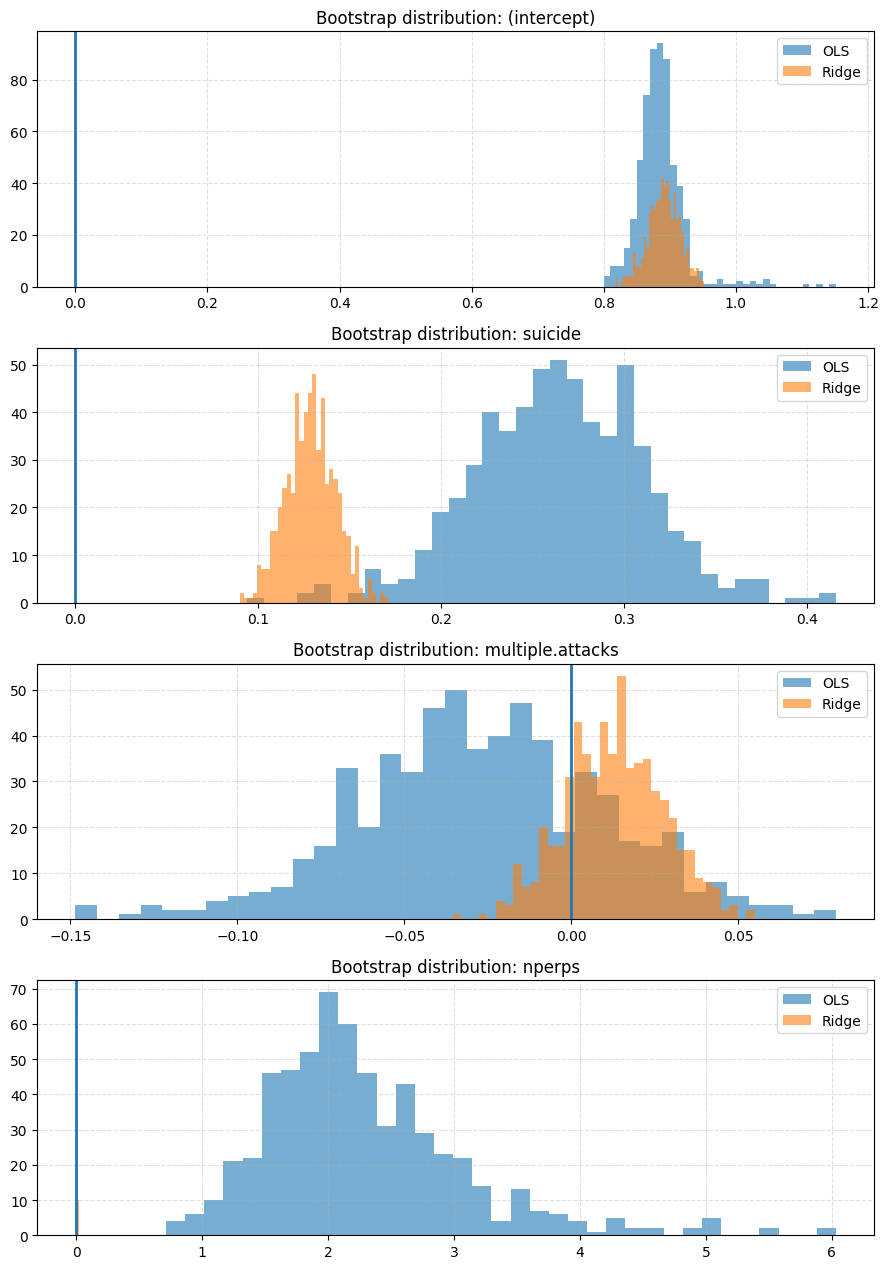

In [17]:
def plot_bootstrap_compare(boot_a, boot_b, names, var_names, label_a="OLS", label_b="Ridge"):
    # Map name -> index
    idx = {n:i for i,n in enumerate(names)}
    chosen = [idx[v] for v in var_names if v in idx]
    if len(chosen) == 0:
        print("No variables found. Available examples:", names[:10])
        return

    n_plots = len(chosen)
    fig, axes = plt.subplots(n_plots, 1, figsize=(9, 3.2*n_plots))
    if n_plots == 1:
        axes = [axes]

    for ax, j in zip(axes, chosen):
        ax.hist(boot_a[:, j], bins=35, alpha=0.6, label=label_a)
        ax.hist(boot_b[:, j], bins=35, alpha=0.6, label=label_b)
        ax.axvline(0, linewidth=2)
        ax.set_title(f"Bootstrap distribution: {names[j]}")
        ax.legend()
        ax.grid(True, linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.show()

# Example: compare a few intuitive parameters (adjust if needed)
vars_to_plot = ['(intercept)'] + example_vars[:3]
plot_bootstrap_compare(boot_ols, boot_ridge, beta_names, vars_to_plot)


# Part 4 — Prediction: Ridge vs OLS (predicted vs observed)

Now we care about **out-of-sample performance**.

We will:
- split train/test
- fit OLS with statsmodels (for prediction intervals)
- fit Ridge with sklearn
- compute simple metrics and plot predicted vs observed

> Why intervals?
> - Good predictions should come with calibrated uncertainty.

## Exercise 4A


In [18]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, log_Y.values.ravel(), test_size=0.30, random_state=42
)

# TODO 4: Add a constant to the OLS design matrices + Fit an OLS model with statsmodels
import statsmodels.api as sm

X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)
ols_model = sm.OLS(y_train, X_train_const).fit()

sem4_topic1_formative1_tests.test_sm_ols_design_and_fit(X_train, X_test, X_train_const, X_test_const, ols_model)

# OLS predictions with prediction intervals
pred = ols_model.get_prediction(X_test_const)
pred_frame = pred.summary_frame(alpha=0.05)

lr_pred = pred_frame["mean"].values
lr_lo = pred_frame["obs_ci_lower"].values
lr_hi = pred_frame["obs_ci_upper"].values

# Ridge fit + predictions
ridge_pred_model = Ridge(alpha=optimal_alpha, fit_intercept=True)
ridge_pred_model.fit(X_train, y_train)
ridge_pred = ridge_pred_model.predict(X_test)

## Exercise 4B

In [19]:
# Bootstrap prediction intervals for ridge
n_boot_pred = 400
ridge_preds_boot = np.zeros((n_boot_pred, len(X_test)))

# TODO 5: Bootstrap loop for ridge prediction intervals
# - resample training indices
# - fit ridge on bootstrap sample
# - store predictions on X_test

for i in range(n_boot_pred):
    idx = resample(np.arange(len(X_train)), replace=True, random_state=123+i)
    
    Xb = X_train[idx]
    yb = y_train[idx]
    m = Ridge(alpha=optimal_alpha, fit_intercept=True)
    m.fit(Xb, yb)
    ridge_preds_boot[i, :] = m.predict(X_test).ravel()

ridge_lo = np.percentile(ridge_preds_boot, 2.5, axis=0)
ridge_hi = np.percentile(ridge_preds_boot, 97.5, axis=0)

sem4_topic1_formative1_tests.test_ridge_bootstrap_prediction_intervals(ridge_preds_boot, n_boot_pred, X_test, ridge_lo, ridge_hi)

In [20]:
# Metrics
def metrics(y, yhat, lo, hi):
    bias = np.mean(yhat - y)
    rmse = np.sqrt(np.mean((yhat - y)**2))
    spear = spearmanr(y, yhat).correlation
    coverage = np.mean((y >= lo) & (y <= hi))
    return bias, rmse, spear, coverage

lr_bias, lr_rmse, lr_spear, lr_cov = metrics(y_test, lr_pred, lr_lo, lr_hi)
rg_bias, rg_rmse, rg_spear, rg_cov = metrics(y_test, ridge_pred, ridge_lo, ridge_hi)

# Table of results
results_df = pd.DataFrame({
    "Model": ["OLS", "Ridge"],
    "Bias": [lr_bias, rg_bias],
    "RMSE": [lr_rmse, rg_rmse],
    "Spearman": [lr_spear, rg_spear],
    "Coverage": [lr_cov, rg_cov]
})
results_df


,Model,Bias,RMSE,Spearman,Coverage
0,OLS,-2.9679,6.6625,0.3362,0.7367
1,Ridge,-0.0391,0.8478,0.4887,0.2733


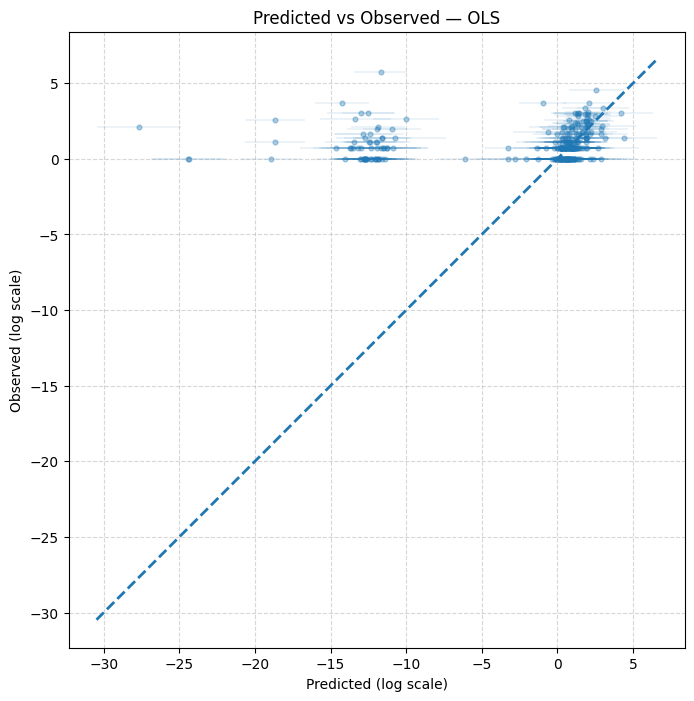

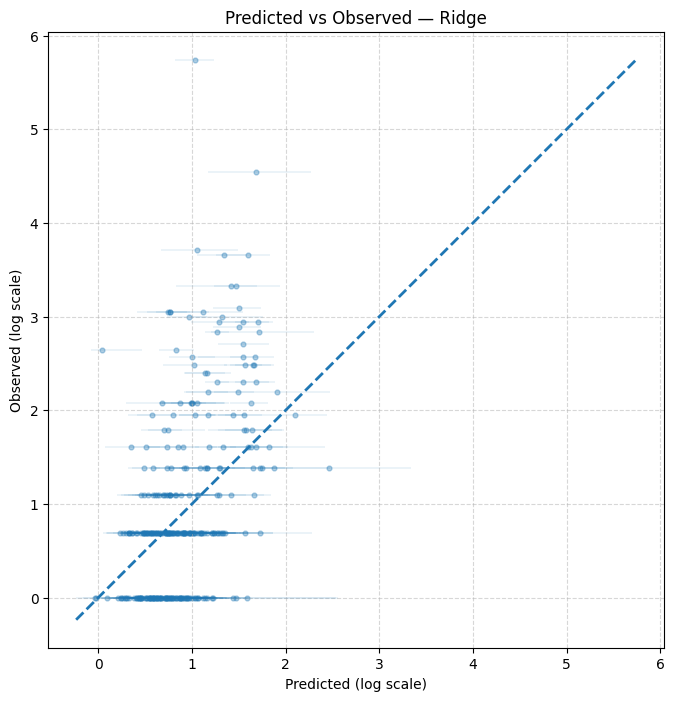

In [21]:
# Predicted vs observed plots (log scale)
def pred_vs_obs(y, yhat, lo, hi, title):
    plt.figure(figsize=(8, 8))
    plt.scatter(yhat, y, s=12, alpha=0.35)
    # horizontal error bars
    err_left = yhat - lo
    err_right = hi - yhat
    plt.errorbar(yhat, y, xerr=[err_left, err_right], fmt="none", lw=0.35, alpha=0.35)
    # 45° line
    mn = min(y.min(), yhat.min(), lo.min())
    mx = max(y.max(), yhat.max(), hi.max())
    plt.plot([mn, mx], [mn, mx], linestyle="--", linewidth=2)
    plt.xlabel("Predicted (log scale)")
    plt.ylabel("Observed (log scale)")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.show()

pred_vs_obs(y_test, lr_pred, lr_lo, lr_hi, "Predicted vs Observed — OLS")
pred_vs_obs(y_test, ridge_pred, ridge_lo, ridge_hi, "Predicted vs Observed — Ridge")
